# Libraries

In [2]:
import os
from statistics import mean

# visualisation
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scikitplot.estimators import plot_learning_curve
from scikitplot.metrics import plot_roc
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['savefig.facecolor'] = "0.8"
plt.rcParams.update({'figure.figsize': (15, 5), 'figure.dpi': 120})
plt.style.use('fivethirtyeight')

# model building
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE 

from sklearn.pipeline import Pipeline , make_pipeline
from imblearn.pipeline import Pipeline as imbpipeline

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, f1_score, recall_score, confusion_matrix, classification_report

# model export
import pickle as pck

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Data Fetching

In [3]:
# define train/test files path
train_path = os.path.join("../data/raw/train.txt")
test_path = os.path.join("../data/test.txt")

In [4]:
# define train/test dataframes
df_train = pd.read_csv(train_path, low_memory=False)
df_test = pd.read_csv(test_path, low_memory=False)

# Data Parsing

In [7]:
# dataset overview
df_train.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [8]:
# dataset summary
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [9]:
# dataset statistic
df_train.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


In [112]:
# dataset null/NaN values count
np.round(df_train.isnull().sum())

gender               13
married               3
dependents           15
education             0
self_employed        32
applicantincome       0
coapplicantincome     0
loanamount           22
loan_amount_term     14
credit_history       50
property_area         0
loan_status           0
dtype: int64

In [7]:
# dataset duplicates count
df_train[df_train.duplicated(keep=False)].sum()

Loan_ID              0.0
Gender               0.0
Married              0.0
Dependents           0.0
Education            0.0
Self_Employed        0.0
ApplicantIncome      0.0
CoapplicantIncome    0.0
LoanAmount           0.0
Loan_Amount_Term     0.0
Credit_History       0.0
Property_Area        0.0
Loan_Status          0.0
dtype: float64

# Exploratory data analysis

In [6]:
# renaming columns for better readability
df_train.columns = df_train.columns.str.lower()

In [7]:
# drop uneedeed/obselete features
df_train = df_train.drop("loan_id", axis=1) 

In [113]:
df_train.head()

,gender,married,dependents,education,self_employed,applicantincome,coapplicantincome,loanamount,loan_amount_term,credit_history,property_area,loan_status
0,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [19]:
df_test

,loan_id,gender,married,dependents,education,self_employed,applicantincome,coapplicantincome,loanamount,loan_amount_term,credit_history,property_area
0,LP001015,Male,Yes,0,Graduate,No,5720,0,110.0,360.0,1.0,Urban
1,LP001022,Male,Yes,1,Graduate,No,3076,1500,126.0,360.0,1.0,Urban
2,LP001031,Male,Yes,2,Graduate,No,5000,1800,208.0,360.0,1.0,Urban
3,LP001035,Male,Yes,2,Graduate,No,2340,2546,100.0,360.0,NaN,Urban
4,LP001051,Male,No,0,Not Graduate,No,3276,0,78.0,360.0,1.0,Urban
...,...,...,...,...,...,...,...,...,...,...,...,...
362,LP002971,Male,Yes,3+,Not Graduate,Yes,4009,1777,113.0,360.0,1.0,Urban
363,LP002975,Male,Yes,0,Graduate,No,4158,709,115.0,360.0,1.0,Urban
364,LP002980,Male,No,0,Graduate,No,3250,1993,126.0,360.0,NaN,Semiurban
365,LP002986,Male,Yes,0,Graduate,No,5000,2393,158.0,360.0,1.0,Rural


In [9]:
# define dataframe for visualization
df_analysis = df_train.copy()

In [10]:
# define continuous / categorical features
continuous_fts = []
categorical_fts = []

for col in df_analysis.columns:
    if df_analysis[col].dtype == "int64" or df_analysis[col].dtype == "float64":
        continuous_fts.append(col)
    else:
        categorical_fts.append(col)

## Univariate analysis

### Distribution plots

In [33]:
# target label encoding target for visualization
df_analysis['loan_status'] = LabelEncoder().fit_transform(df_analysis['loan_status'])

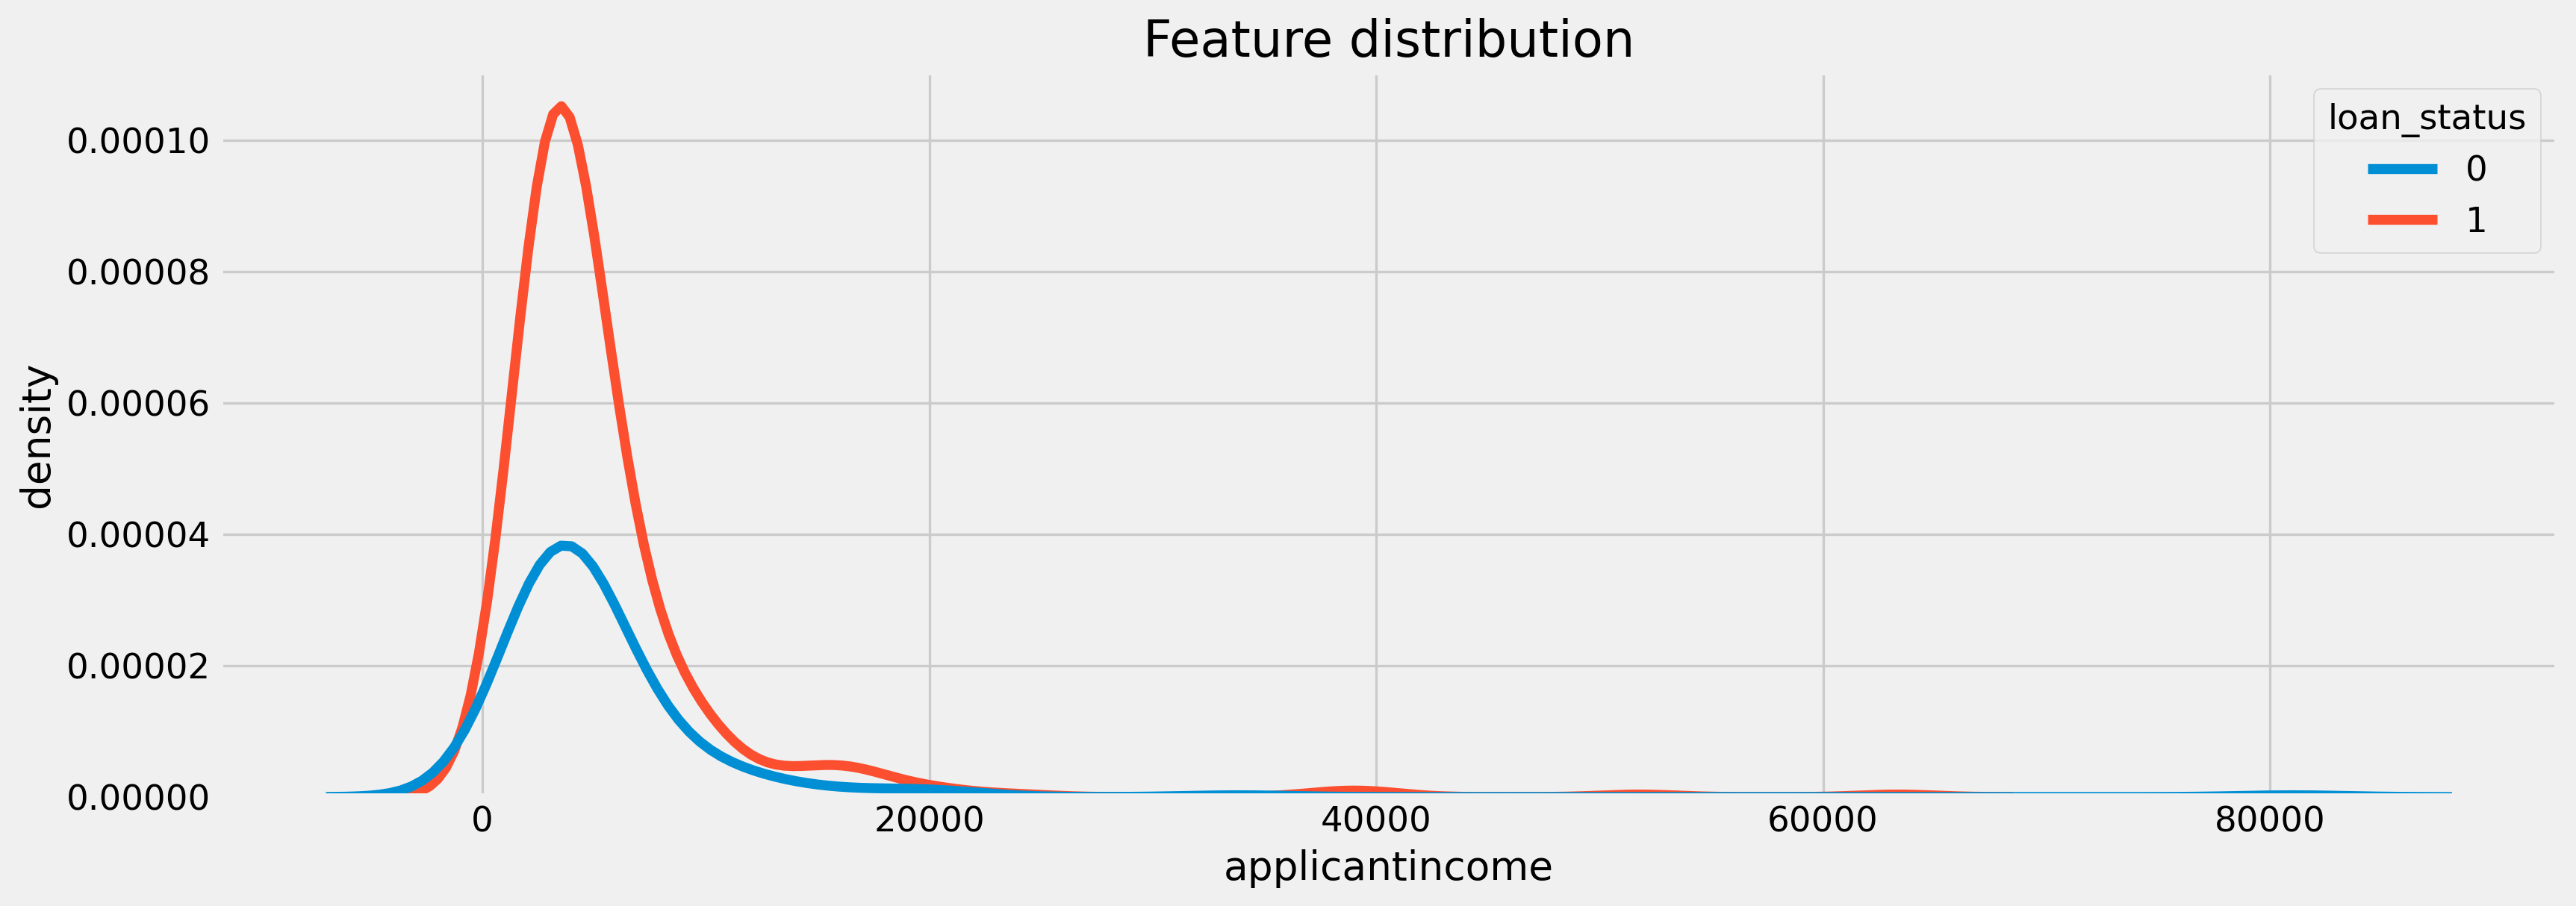

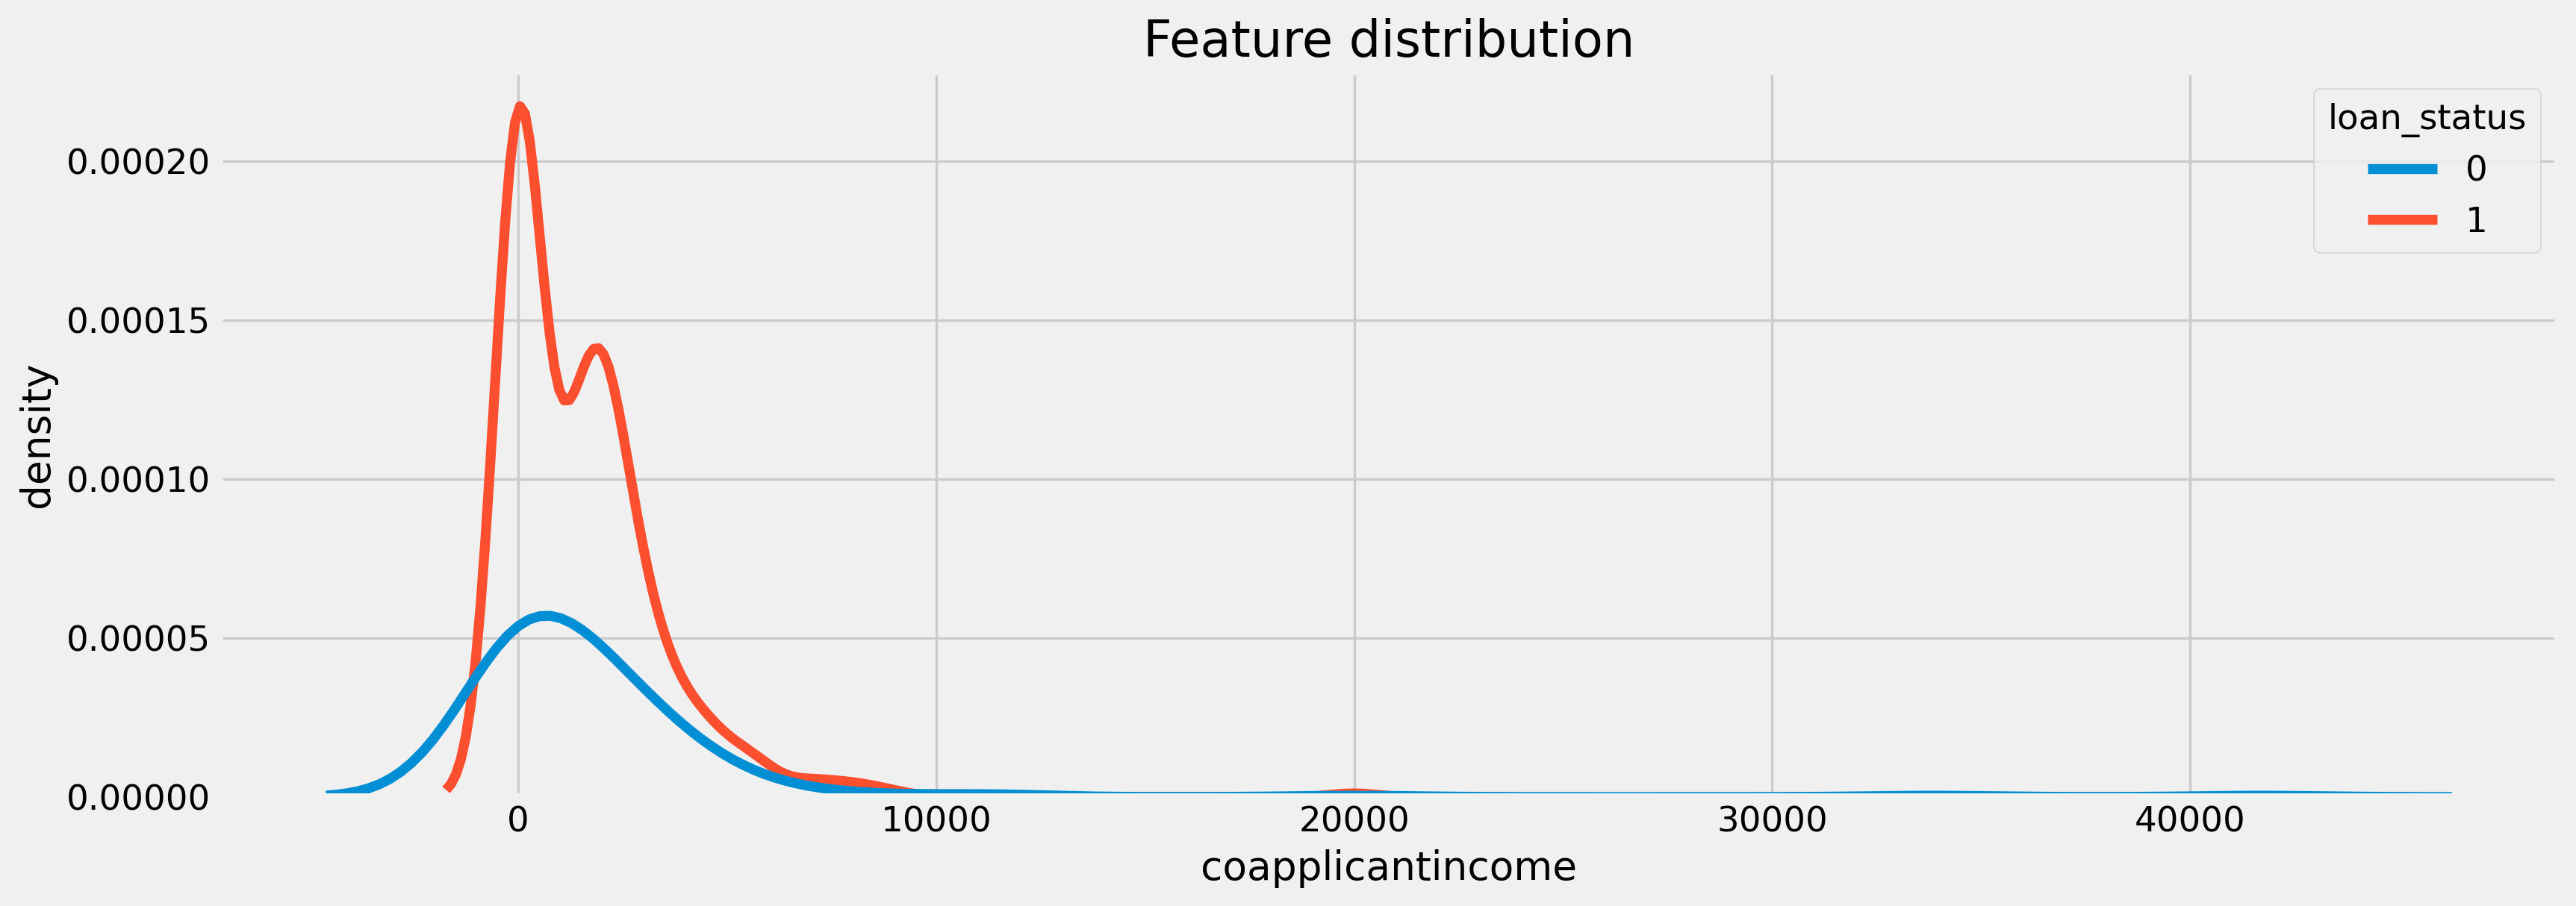

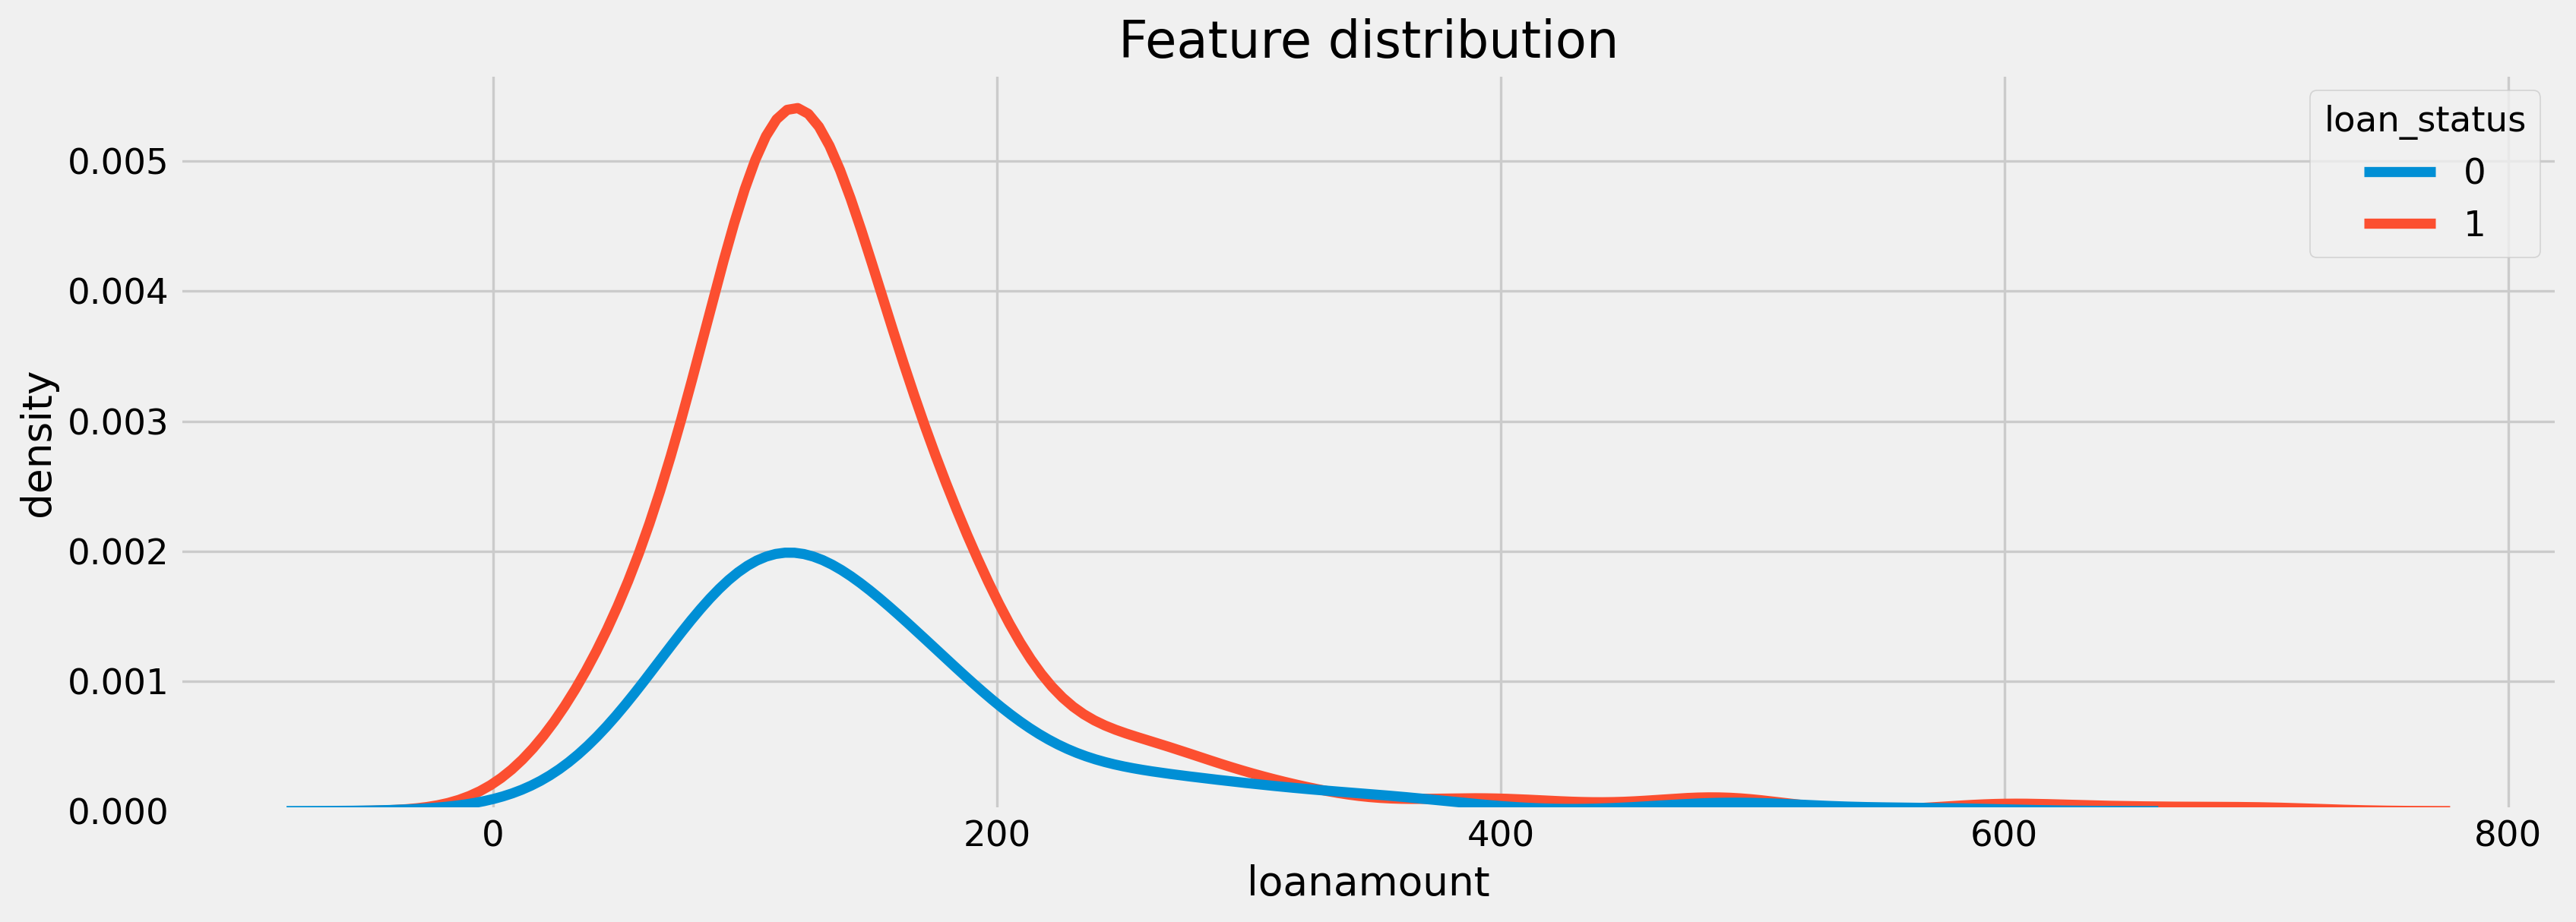

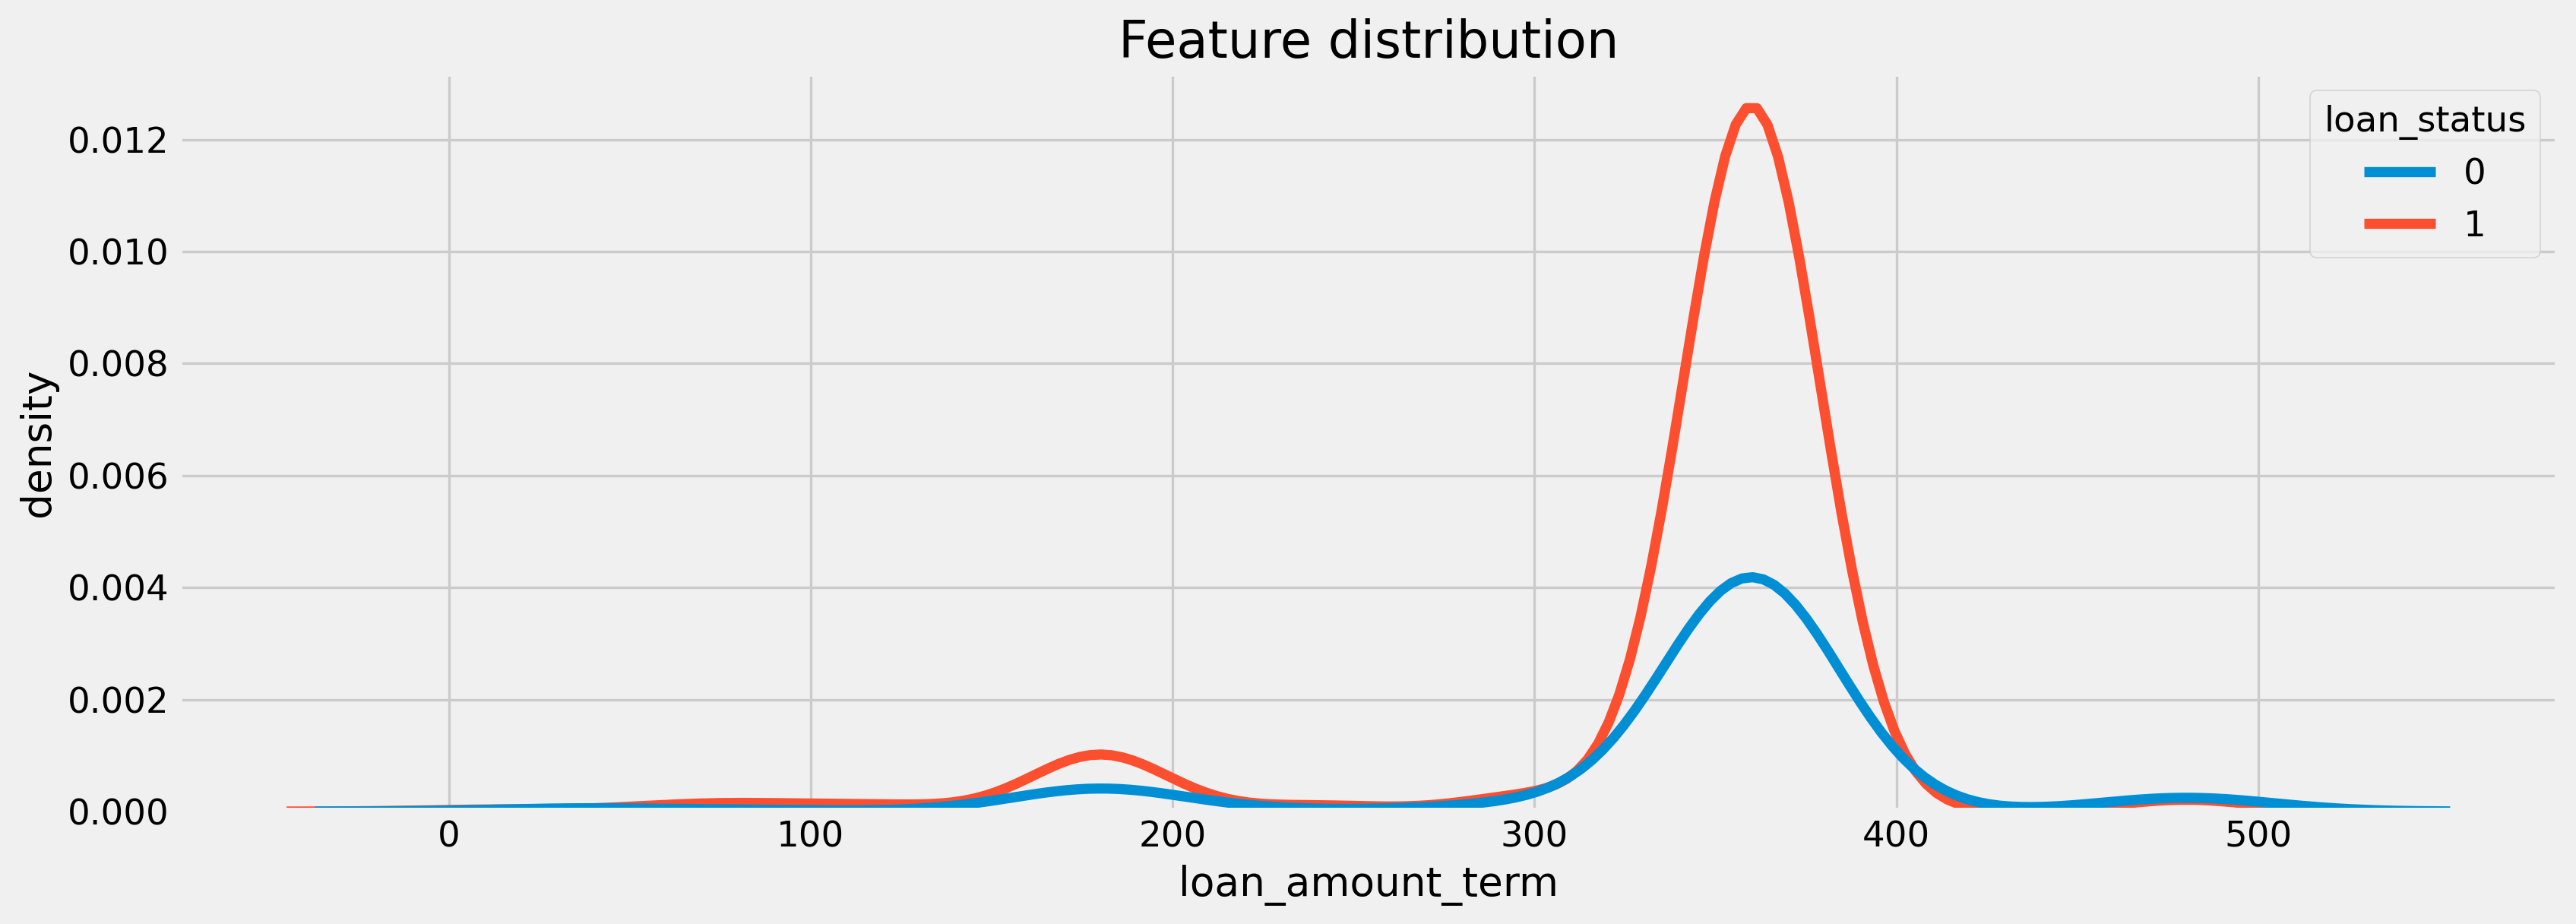

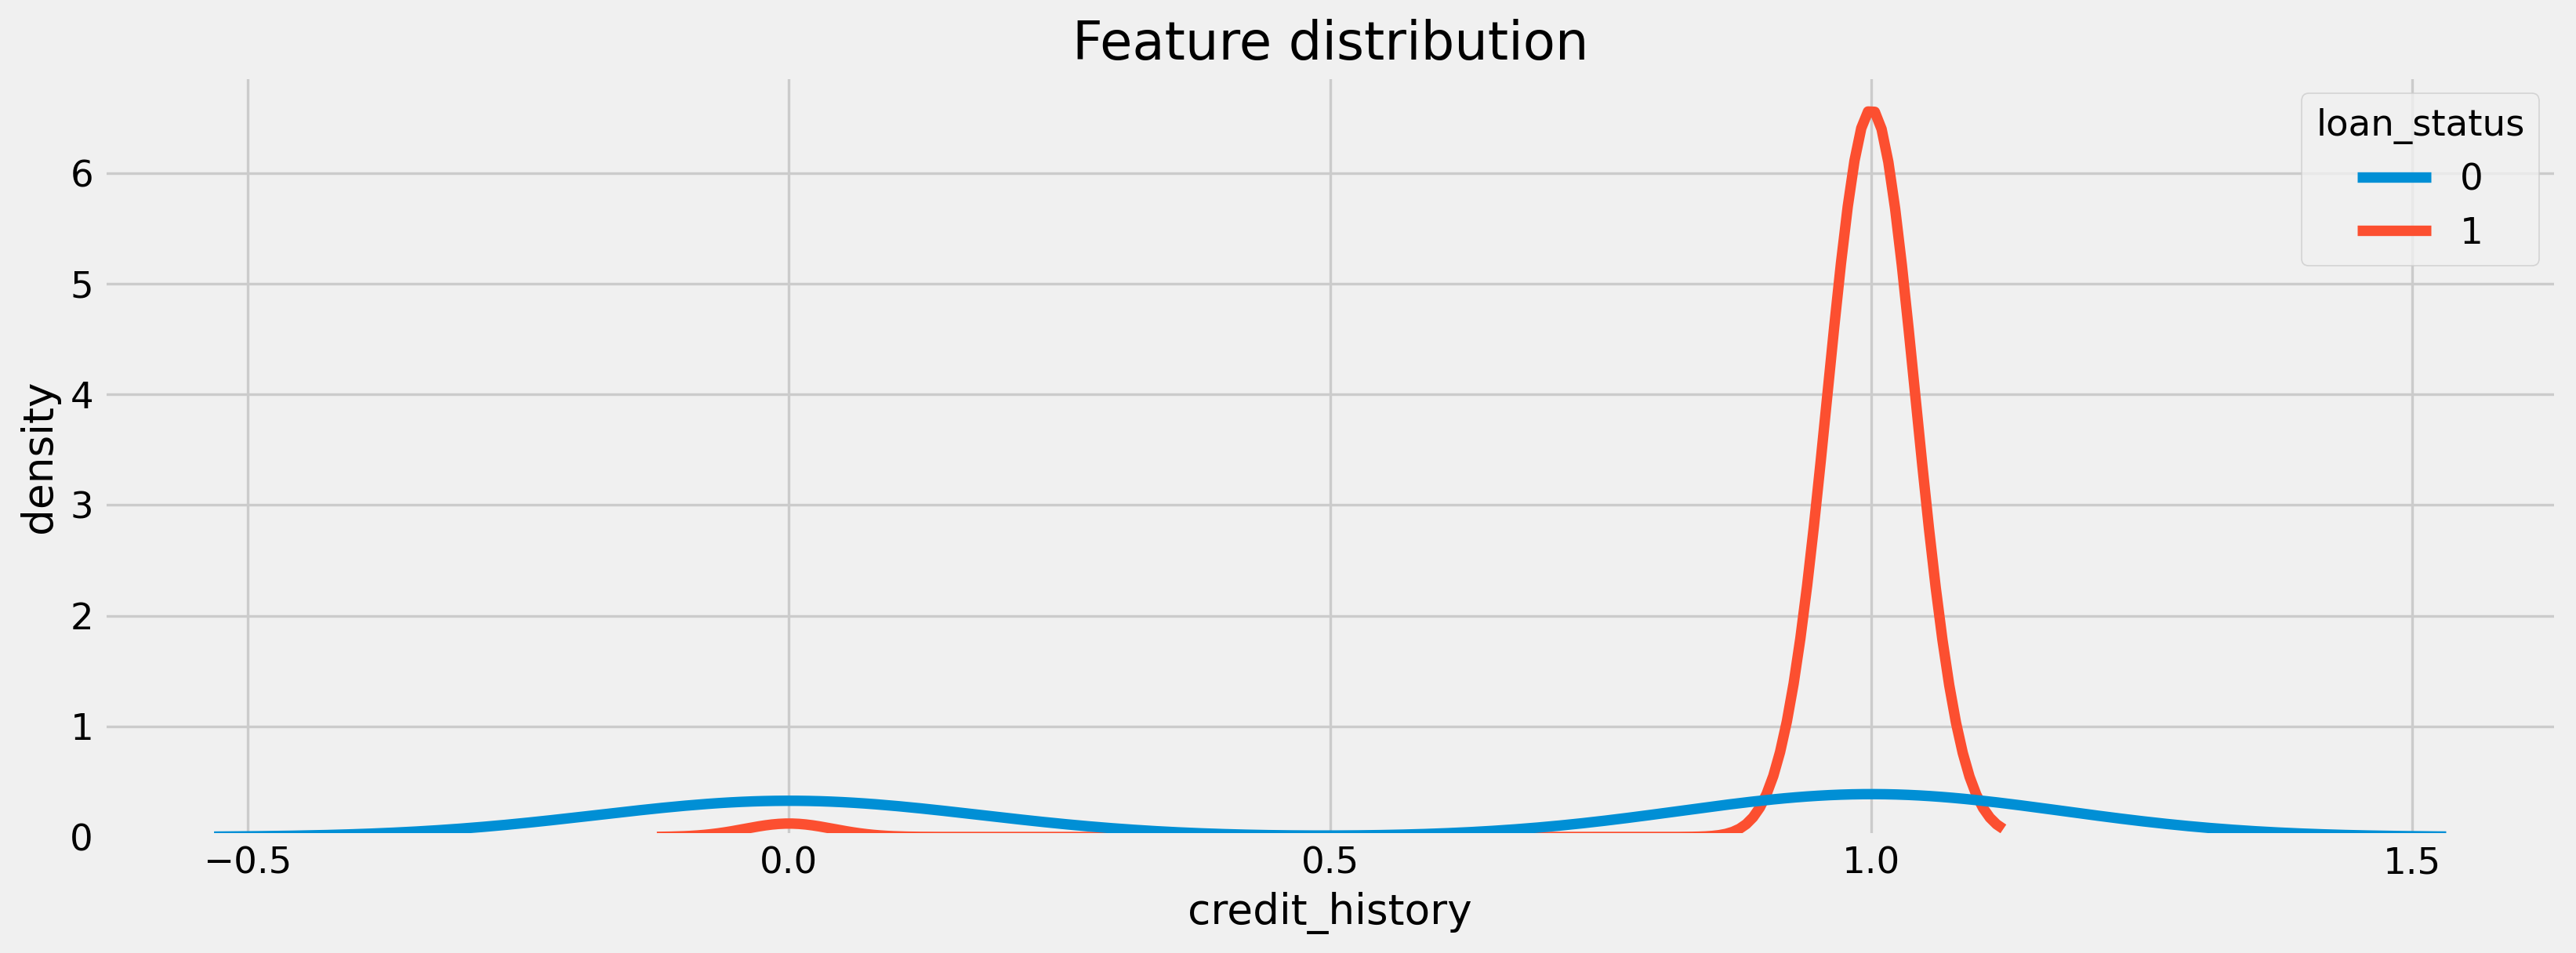

In [98]:
# plot continuous numeric features distribution against target
for i in continuous_fts:
    plt.figure()
    plt.title("Feature distribution")
    plt.xlabel(i, fontsize=16)
    plt.ylabel("density", fontsize=16)
    sns.kdeplot(df_analysis[i], hue=df_analysis['loan_status'])

plt.savefig('../reports/eda/num_ftr_distribution.png')
plt.show()

### Count plots

In [11]:
# drop target feature from categorical features list
categorical_fts.remove('loan_status')

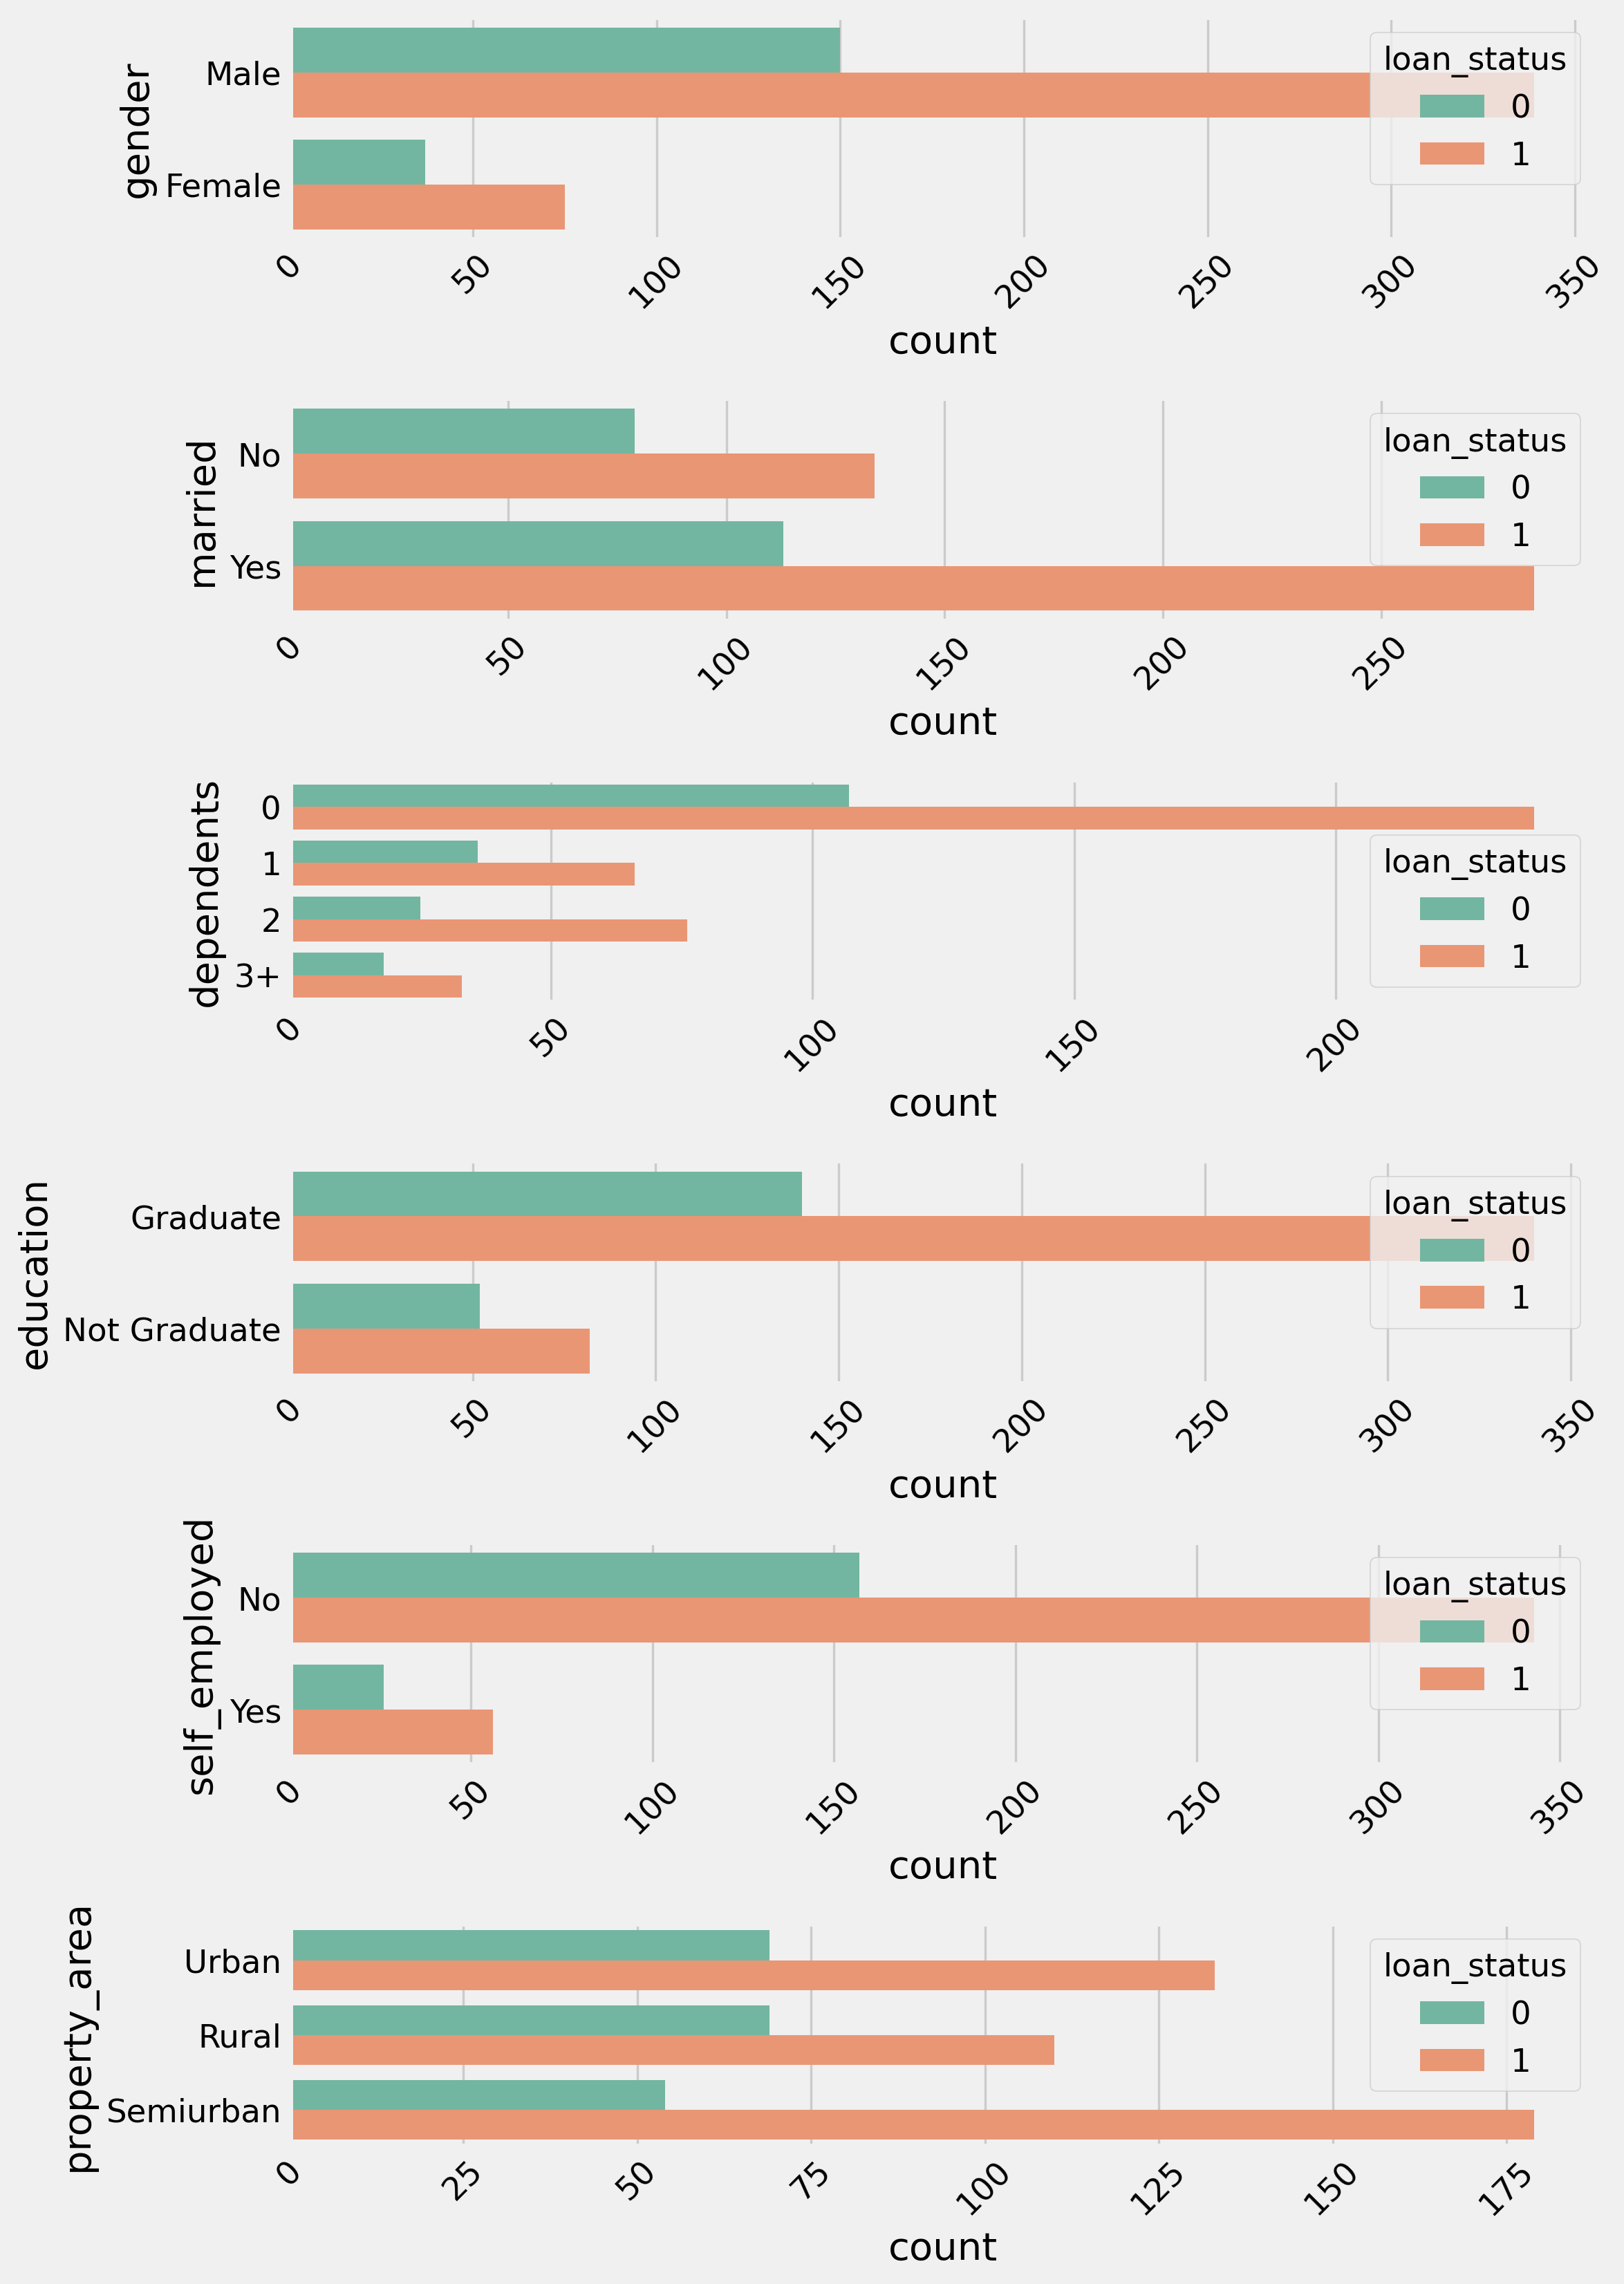

In [90]:
# count plot categorical features
c_map = sns.color_palette("Set2")

fig, axes = plt.subplots(len(categorical_fts), figsize=(10, 14))
for i, ax in enumerate(axes):
    sns.countplot(y=categorical_fts[i], data=df_analysis[categorical_fts], hue=df_analysis['loan_status'], palette=c_map, ax=ax)

# rotate x-axis for every single plot
for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=45)

# set spacing for every subplot, else x-axis will be covered
plt.tight_layout()

# export report figure
plt.savefig('../reports/eda/ctg_ftr_count.png')

### Box plots

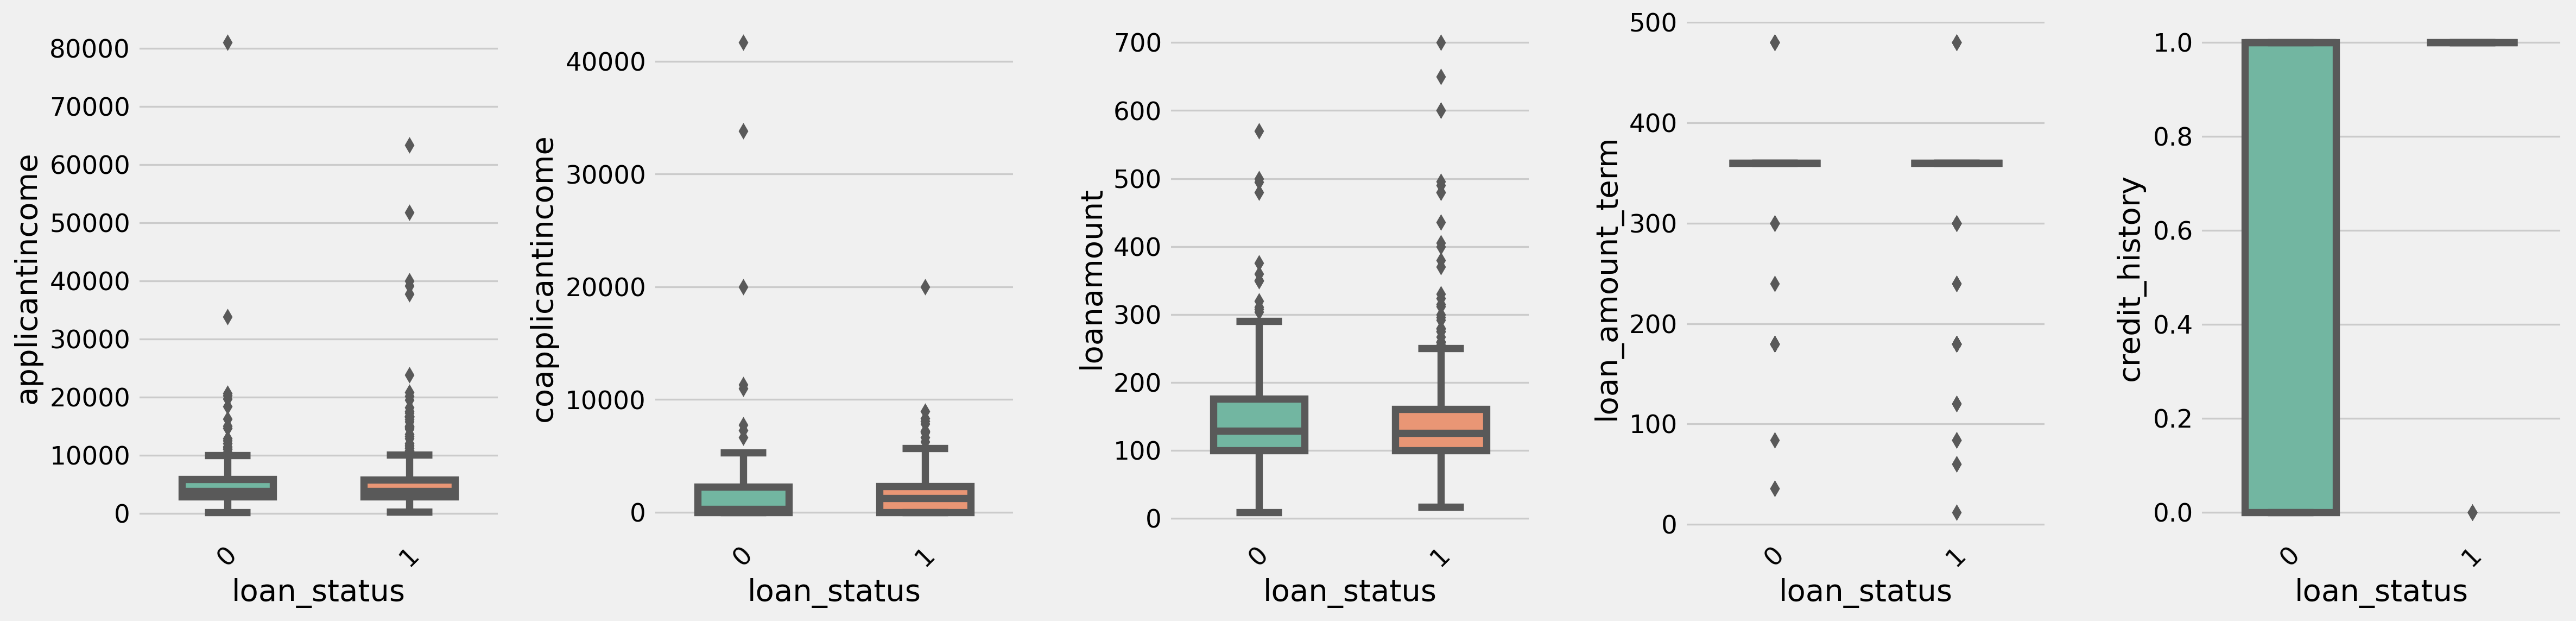

In [93]:
# box plot continuous features for outliers spotting / high prediction importance ("if they do not overlap"?)
c_map = sns.color_palette("Set2")

fig, axes = plt.subplots(ncols=5, figsize=(20, 5))
for i, ax in enumerate(axes):
    sns.boxplot(x=df_analysis['loan_status'], y=continuous_fts[i], data=df_analysis[continuous_fts], palette=c_map, width=0.5, ax=ax)

# rotate x-axis for every single plot
for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=45)

# set spacing for every subplot, else x-axis will be covered
plt.tight_layout()

# export report figure
plt.savefig('../reports/eda/num_ftr_boxplt_outliers.png')

## Target frequency

1    68.729642
0    31.270358
Name: loan_status, dtype: float64


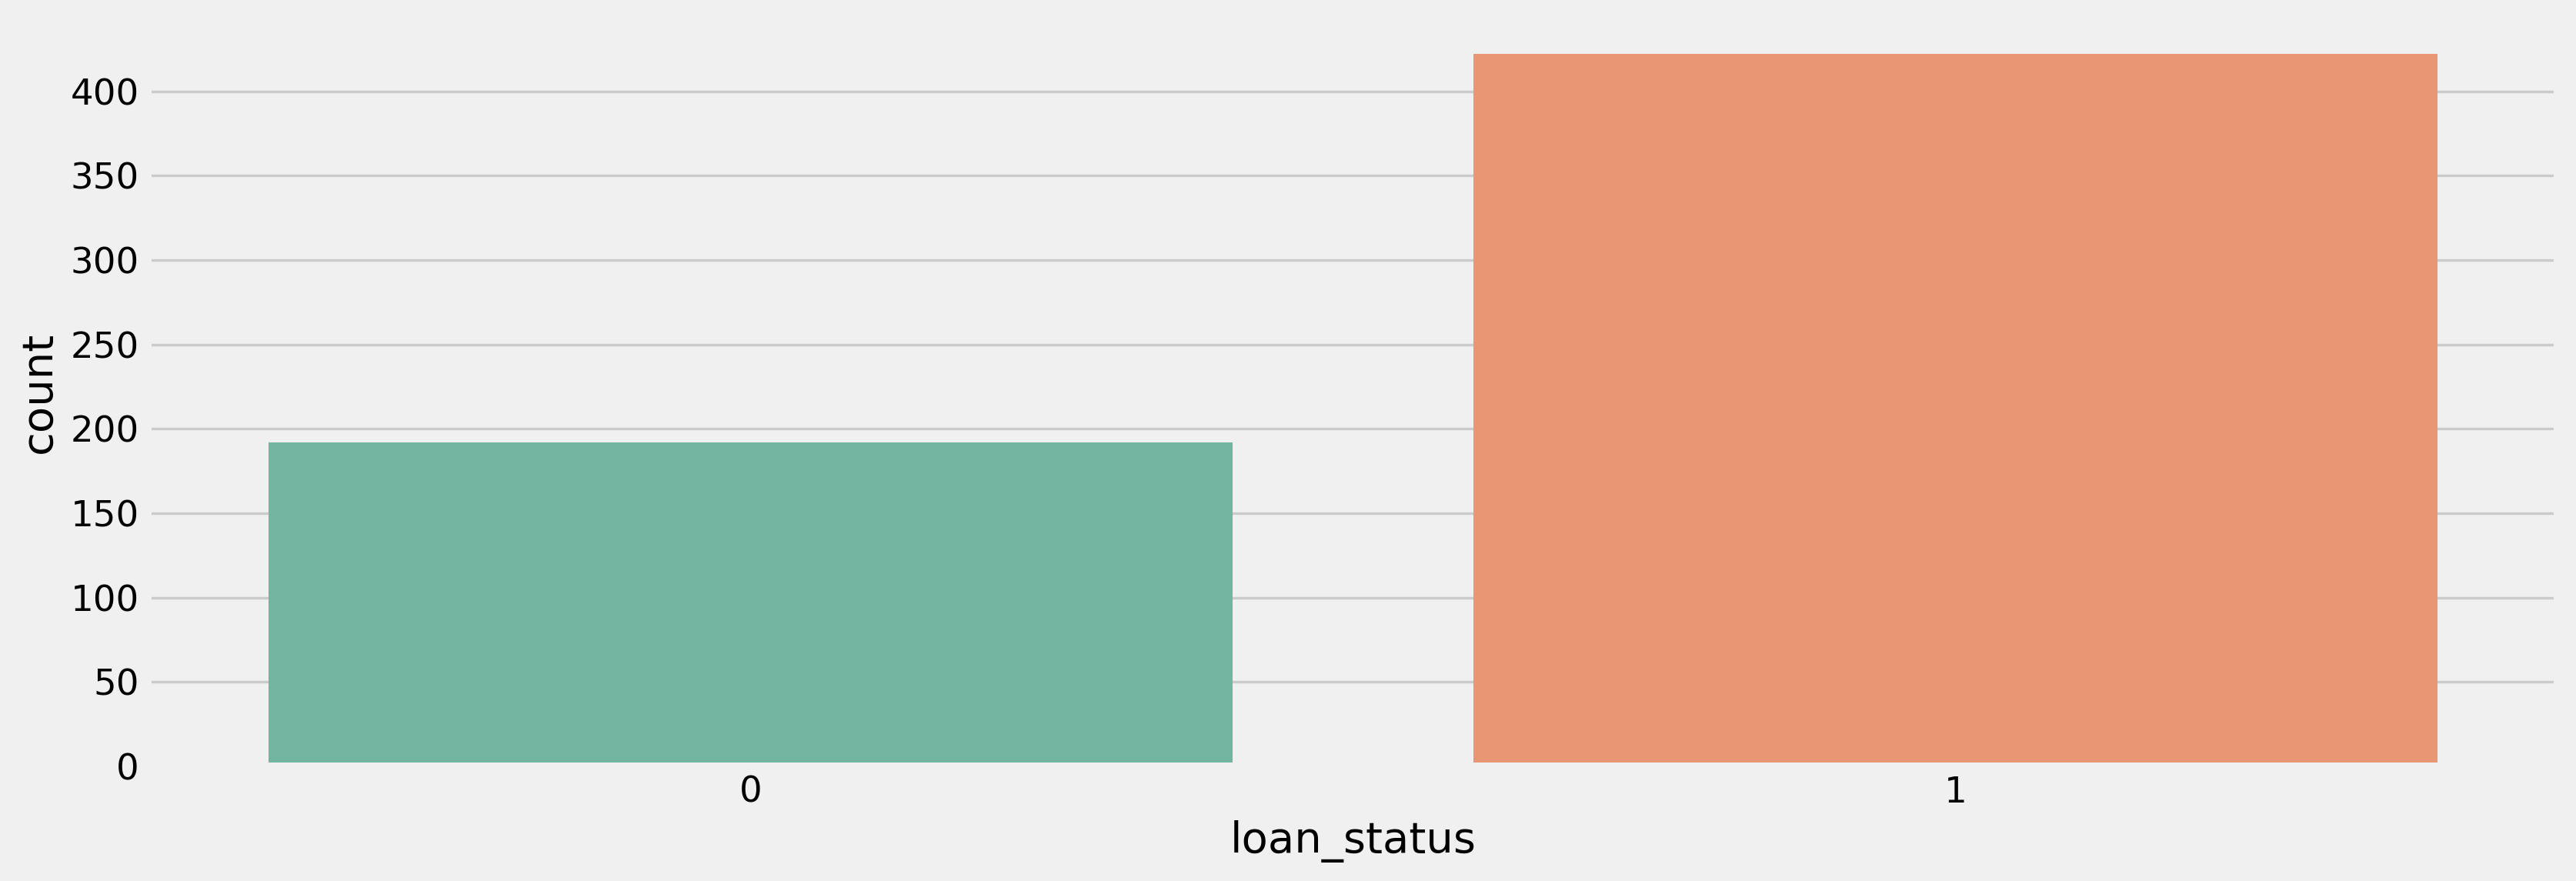

In [95]:
# count plot target feature distribution
sns.countplot(df_analysis['loan_status'], palette=c_map)
print(df_analysis['loan_status'].value_counts() / len(df_analysis['loan_status']) * 100)

# export report figure
plt.savefig('../reports/eda/target_frequency.png')

## Multivariate analysis

### Correlation

In [99]:
# encode categorical features for heatmap plotting
for col in categorical_fts:
    df_analysis[col] = LabelEncoder().fit_transform(df_analysis[col])
    df_analysis[col].unique()

In [106]:
# heatmap plot features -> target correlation
sns.heatmap(df_analysis.corr()[["loan_status"]].sort_values("loan_status").tail(10), vmax=1, vmin=-1, cmap=c_map, annot=True, ax=ax);

<Figure size 1800x600 with 0 Axes>

# Model building

## Data preprocessing 

In [12]:
# preprocess data before model instantiation
df_train = df_train.dropna()

In [13]:
# features / target split
X = df_train.drop("loan_status", axis=1)
y = df_train["loan_status"]

le = LabelEncoder()
X[categorical_fts] = X[categorical_fts].apply(le.fit_transform)

In [14]:
# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [15]:
logistic_pipe = imbpipeline([('smote', SMOTE()), ('scaling', StandardScaler()),
                                    ('logistic_regression', LogisticRegression())])

## Model instantiation

In [16]:
logistic_pipe.fit(X_train , y_train) 

Pipeline(steps=[('smote', SMOTE()), ('scaling', StandardScaler()),
                ('logistic_regression', LogisticRegression())])

## Performance checking

<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

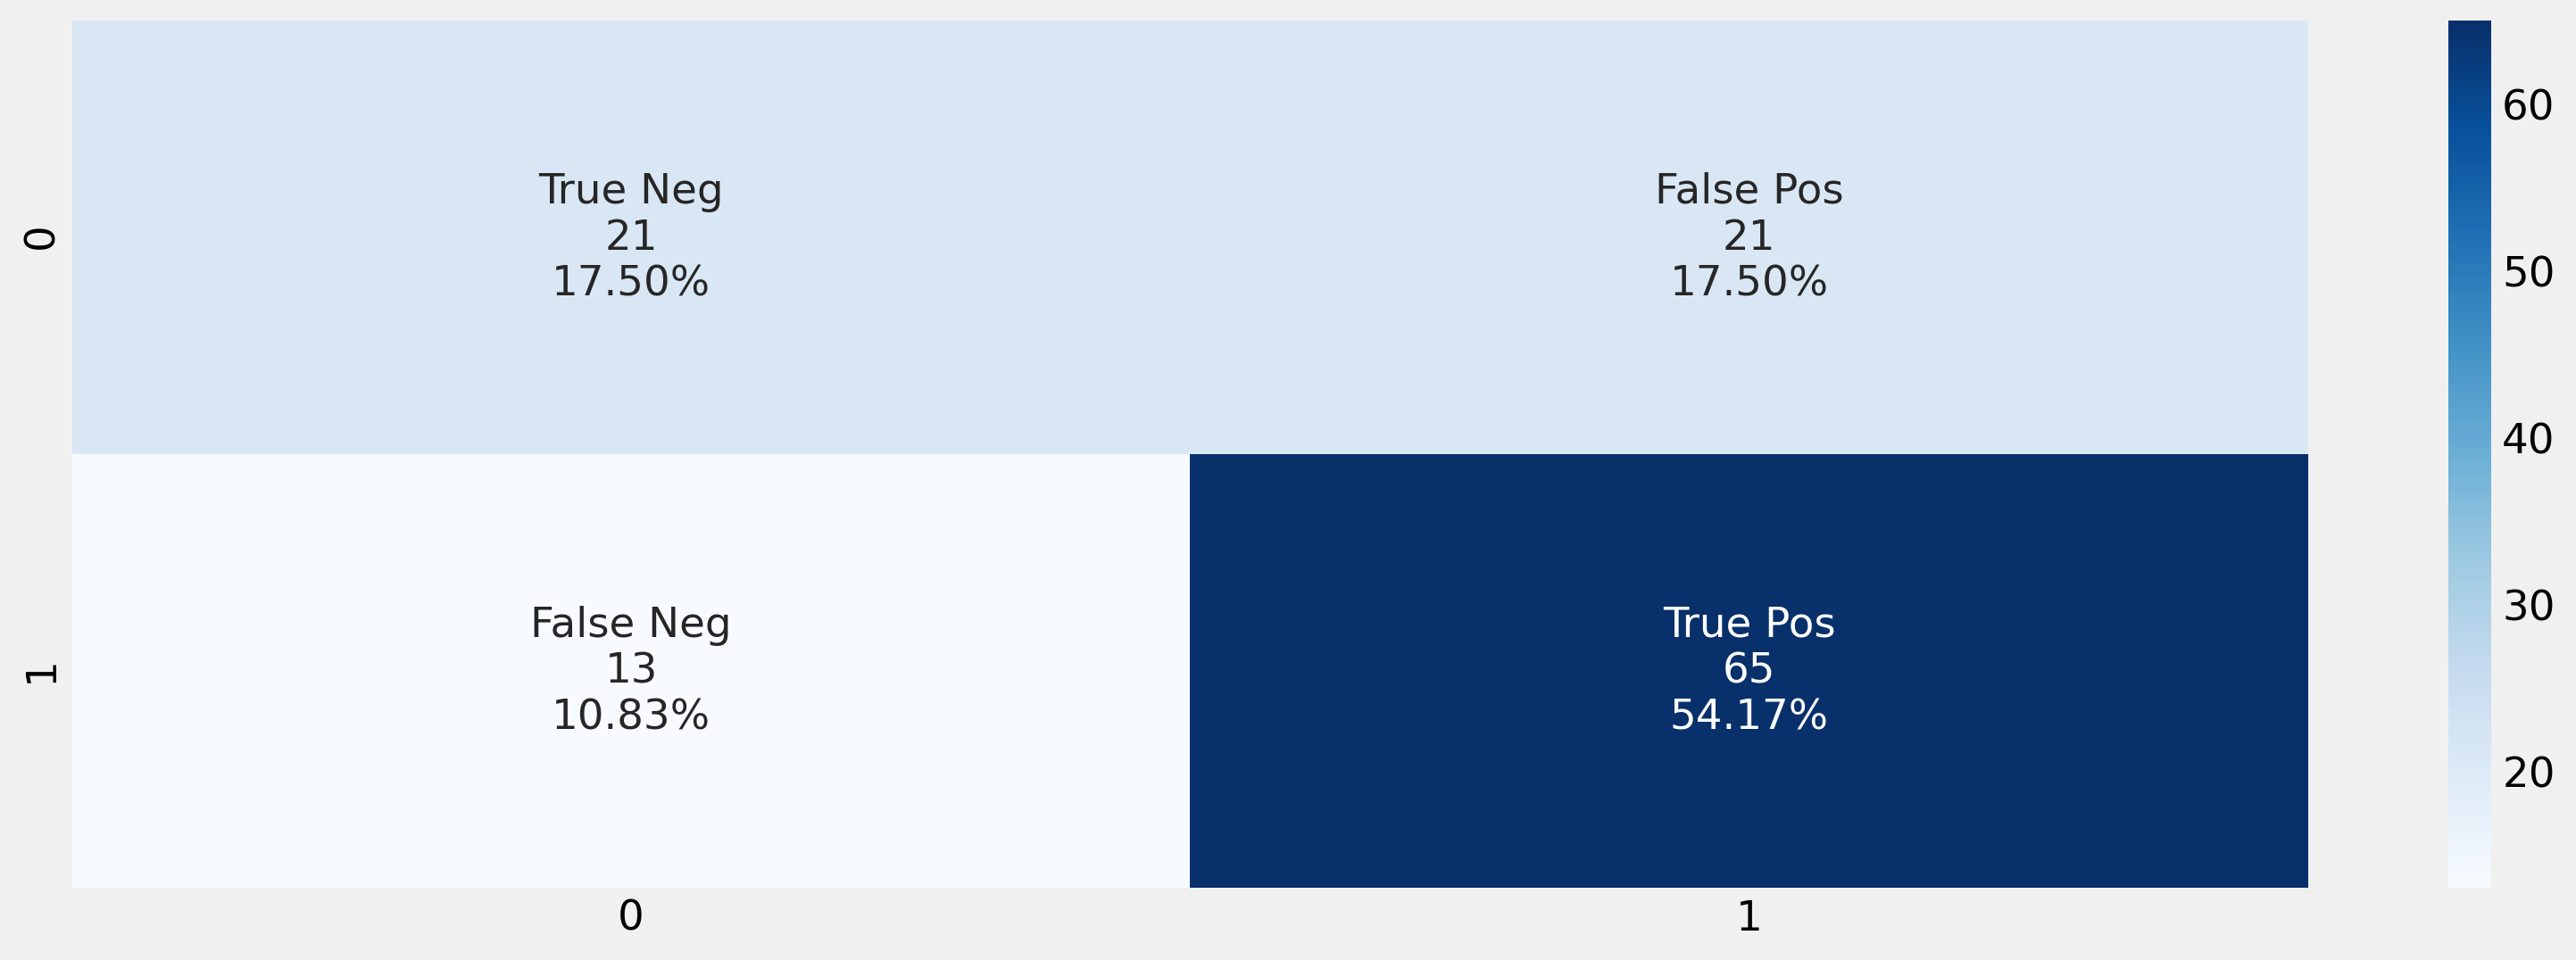

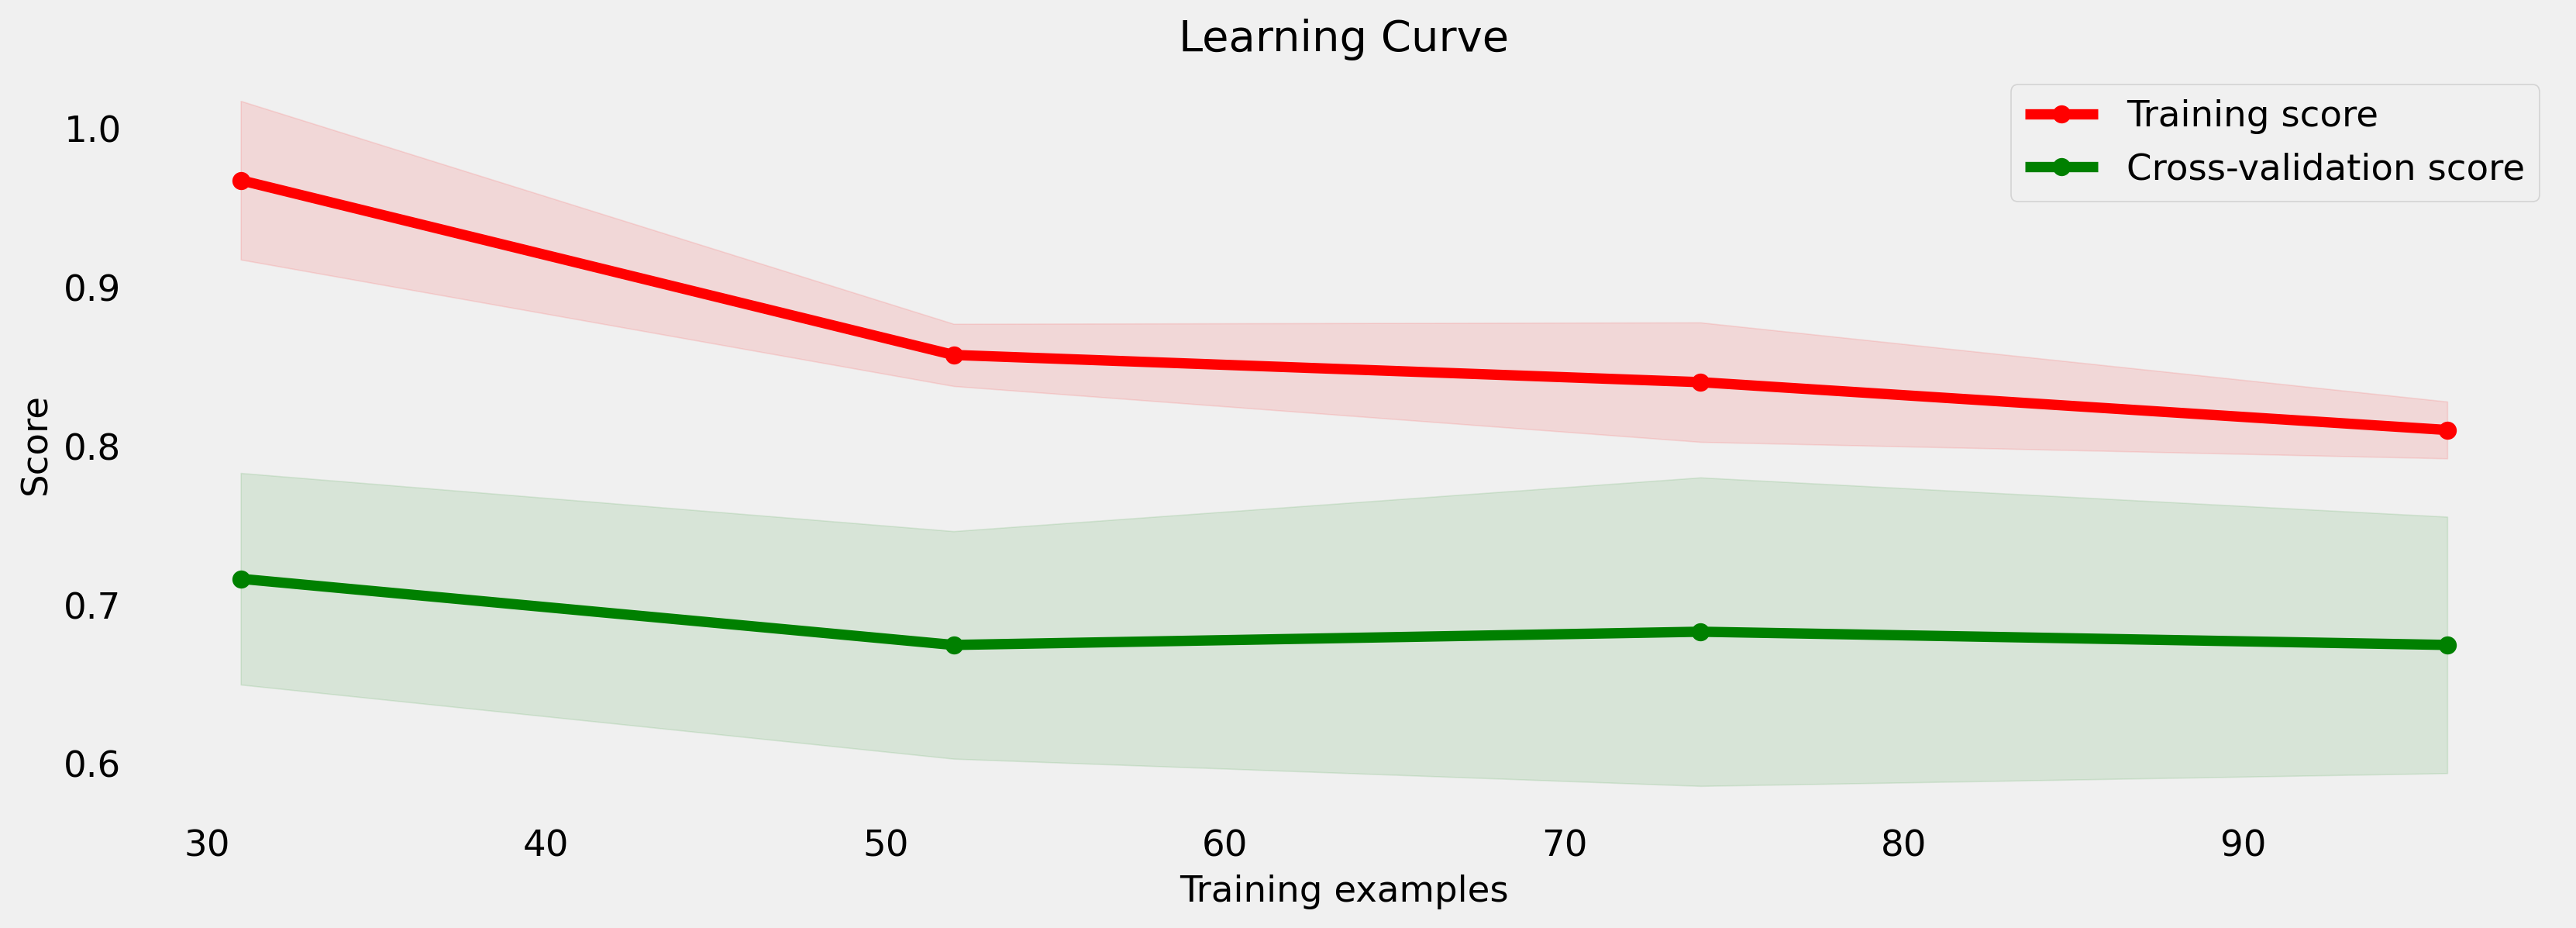

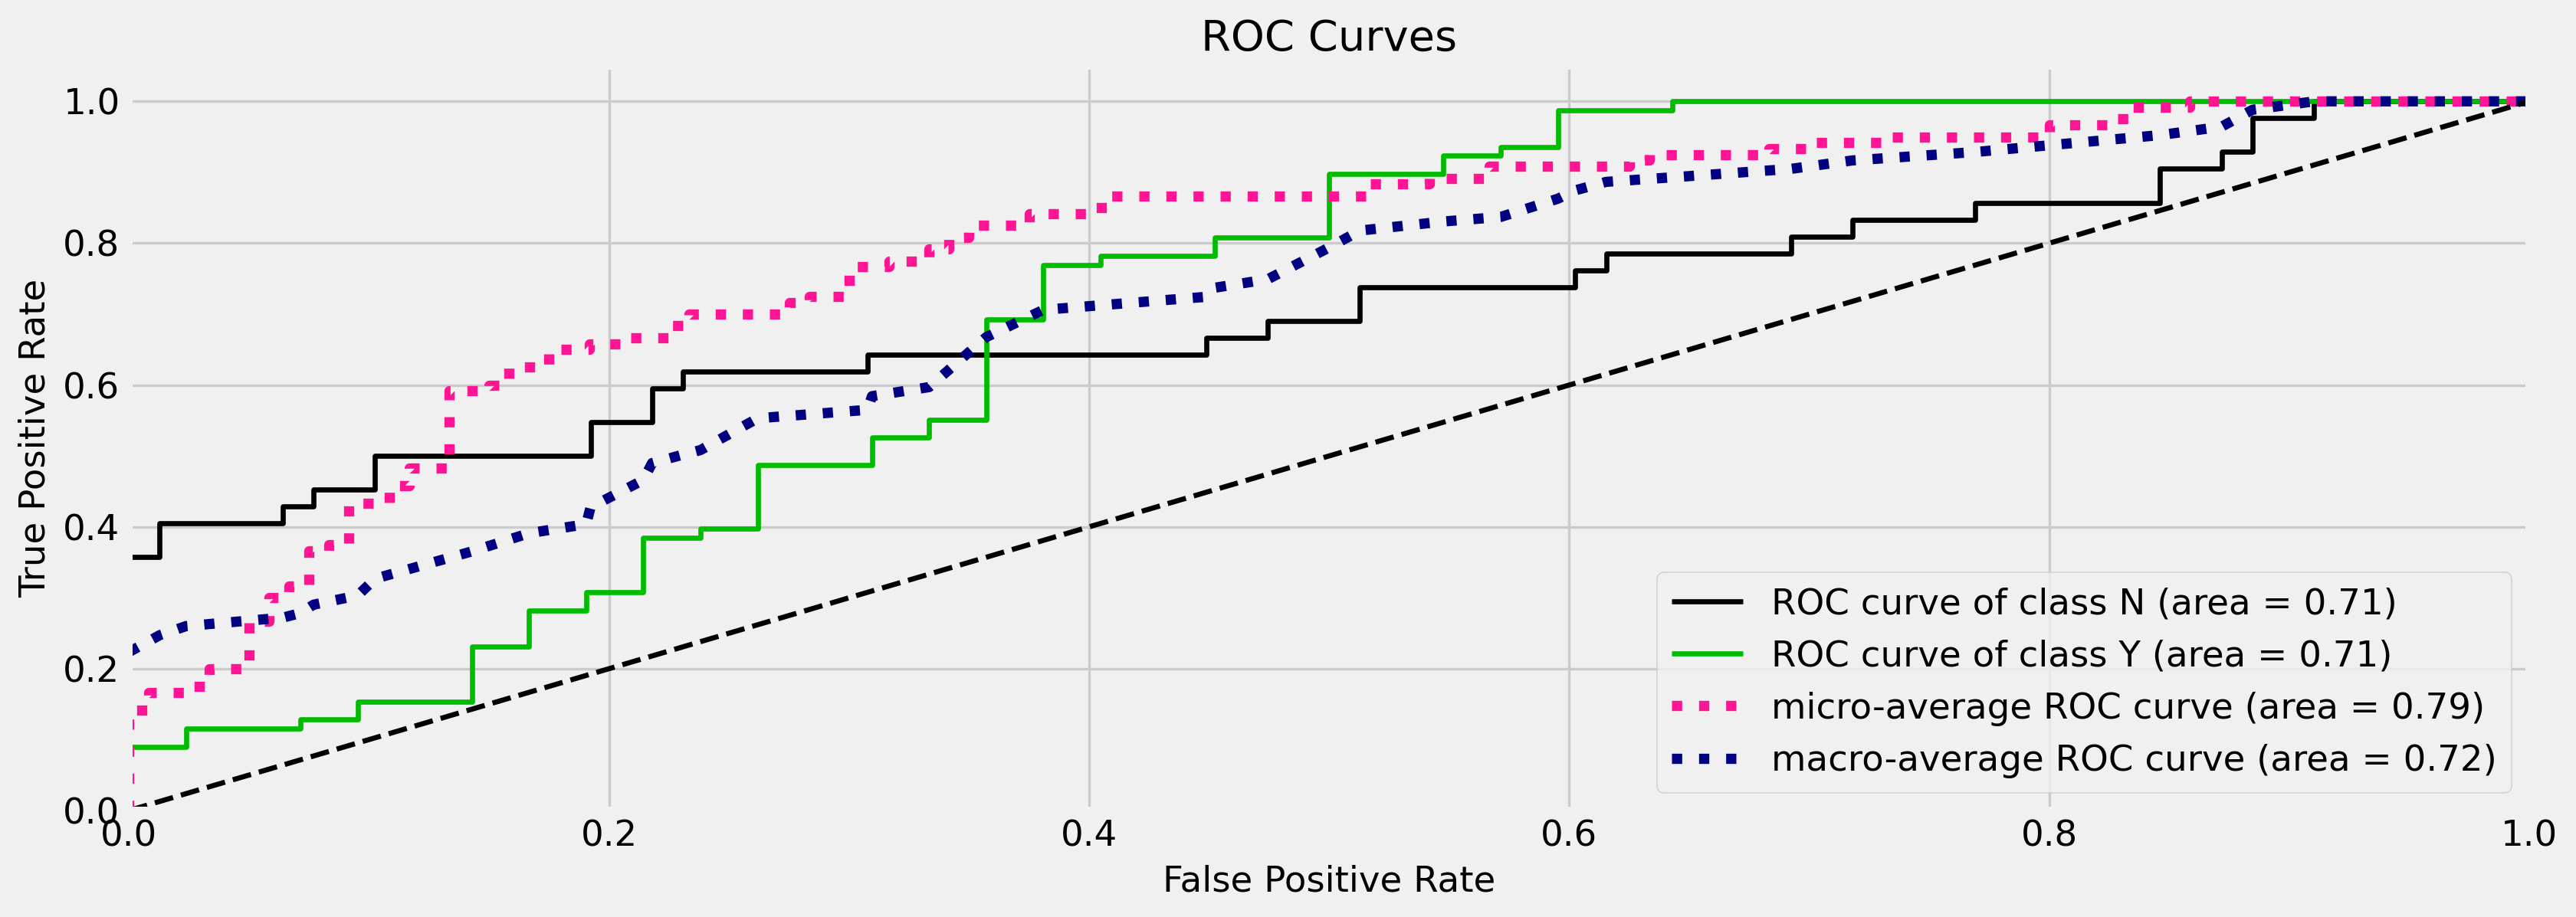

In [181]:
y_pred = logistic_pipe.predict(X_test)
y_probas = logistic_pipe.predict_proba(X_test)

cf_matrix = confusion_matrix(y_test, y_pred)

labels = ["True Neg", "False Pos", "False Neg", "True Pos"]

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(labels, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
plot_learning_curve(logistic_pipe, X_test, y_test)
plot_roc(y_test, y_probas)

## Model Export

In [17]:
# export model into pickle format
with open('../models/model_pkl', 'wb') as file:
    pck.dump(logistic_pipe, file)

-------------------------------

## Model Testing

In [5]:
# model test
model = pck.load(open("../models/model_pkl", 'rb'))

In [53]:
# preprocessing data
def preprocessing_data(df):
    df = df.dropna() ## drop NaN / missing values
    df.columns = df.columns.str.lower() ## renaming columns for better readability
    df = df.drop("loan_id", axis=1) ## drop uneedeed/obselete features
    y = df["loan_status"] ## target selection for model performance checking

    # define continuous / categorical features
    continuous_fts = []
    categorical_fts = []

    for col in df.columns:
        if df[col].dtype == "int64" or df[col].dtype == "float64":
            continuous_fts.append(col)
        else:
            categorical_fts.append(col)

    le = LabelEncoder()
    df[categorical_fts] = df[categorical_fts].apply(le.fit_transform)

    X = df.drop("loan_status", axis=1)

    return X, y


In [117]:
# model presdict and performance check
X, y = preprocessing_data(df_train[df_train.index == 64])
y_pred = model.predict(X)
y_pred[0]

'N'

In [66]:
recall_score(y, y_pred, average="weighted")

1.0

In [121]:
import requests

headers = {
    'accept': 'application/json',
    'Content-Type': 'application/json',
}

# data = '{"sepal_length": 6.2,"sepal_width": 3.4,"petal_length": 5.4,"petal_width": 2.3}'

data = {
  "Gender": "Male",
  "Married": "No",
  "Dependents": 0,
  "Education": "Graduate",
  "Self_Employed": "No",
  "ApplicantIncome": 120000,
  "CoapplicantIncome": 0,
  "LoanAmount": 500.0,
  "Loan_Amount_Term": 300,
  "Credit_History": 0.7,
  "Property_Area": "Urban"
}

response = requests.post('http://127.0.0.1:8000/predict', headers=headers, data=data)
response.text

'{"detail":"Method Not Allowed"}'

---------------